In [1]:
!nvidia-smi

Sat Nov  7 02:20:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install --upgrade opencv-python
!pip install import_ipynb
!pip install latex2mathml
!pip install --upgrade matplotlib
!pip install flask

Requirement already up-to-date: opencv-python in /usr/local/lib/python3.6/dist-packages (4.4.0.46)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.3.2)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import cv2
print(cv2.__version__)
import numpy as np
import matplotlib
print(matplotlib.__version__)
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import import_ipynb

%cd /content/drive/My Drive/Final Project/Khang
from equations_solver import eq_solver
import os
from sympy.parsing.sympy_parser import parse_expr
import latex2mathml.converter
import urllib.request
from flask import Flask, flash, request, redirect, url_for, render_template, send_from_directory, send_file, Markup
from werkzeug.utils import secure_filename
import os
import time


4.4.0
3.3.2
/content/drive/My Drive/Final Project/Khang
importing Jupyter notebook from equations_solver.ipynb


In [5]:
class yolov4:
  def __init__(self,image, net, label):
    # self.weight_path = weight_path
    # self.config_path = config_path
    self.label = label
    self.image = image
    self.net = net

  def detection(self, confidence_threshold, NMS_threshold):
    h,w,_ = self.image.shape

    #net = cv2.dnn.readNet(self.weight_path, self.config_path)
    layer_names = self.net.getLayerNames()
    output_layers = [layer_names[i[0] -1] for i in self.net.getUnconnectedOutLayers()]

    blob = cv2.dnn.blobFromImage(self.image, 1/255., (416,416), swapRB = True, crop = False)
    
    self.net.setInput(blob)
    layer_outputs = self.net.forward(output_layers)

    boxes = []
    confidences = []
    class_ids = []
    for output in layer_outputs :
      for detection in output :
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        
      
        if confidence > confidence_threshold :

          center_x, center_y, width, height = list(map(int, detection[0:4] * [w,h,w,h]))

          top_left_x = int(center_x - (width/2) )
          top_left_y = int(center_y - (height/2) )

          boxes.append([top_left_x, top_left_y, width, height])
          confidences.append(float(confidence))
          class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, NMS_threshold)
    self.num_obj = len(indexes)

    list_coor = []
    crop_scale = 0.05
    if len(indexes) > 0:
      for i in indexes.flatten():
        x, y, w, h = boxes[i]
        x = abs(int(x - crop_scale*w))
        y = abs(int(y - crop_scale*h))
        w = abs(int((1 + 2*crop_scale)*w))
        h = abs(int((1 + 2*crop_scale)*h))

        list_coor.append((x,y,w,h))
      
    list_coor = sorted(list_coor, key = lambda x : x[0])

    return [[x,y,w,h] for x,y,w,h in list_coor]  

  def __str__(self):
    return "Number of object detected: {}".format(self.num_obj)

  def num(self):
    return self.num_obj

In [6]:
%cd /content/drive/My Drive/Final Project/Khang/darknet
!make
!sudo chmod +x darknet


/content/drive/My Drive/Final Project/Khang/darknet
chmod +x *.sh


In [7]:
def show_image(image_list):
  for image in image_list:
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.axis('off')

In [8]:
def ocr(list_image) :
  eq_str =""
  for image in list_image :
    preprocess_image = preprocessing_image(image)
    y_predict = model.predict(preprocess_image.reshape(1,28,28,1))
    text_predict = names[np.argmax(y_predict)]
    print(text_predict, np.max(y_predict))
    if np.max(y_predict) >= 0.5 :
      eq_str += text_predict
  return eq_str

In [9]:
def preprocessing_image(image):

  image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image_blur = cv2.medianBlur(image_gray, 3)
  ret, thresh = cv2.threshold(image_blur, 120, 255, cv2.THRESH_BINARY+ cv2.THRESH_OTSU)
  image_bw = cv2.bitwise_not(thresh)

  #Padding
  h, w = image_gray.shape
  pad_size = int(abs(h-w)/2)
  pad_extra = abs(h-w)%2
  image_padding = np.array([])
  if h > w:
    image_padding = cv2.copyMakeBorder(image_bw, 0,0, pad_size + pad_extra, pad_size, cv2.BORDER_CONSTANT, value = [0,0,0])
    image_padding = cv2.copyMakeBorder(image_padding, 2,2,2,2, cv2.BORDER_CONSTANT, value = [0,0,0])
  elif w > h :
    image_padding = cv2.copyMakeBorder(image_bw,pad_size + pad_extra, pad_size,0,0, cv2.BORDER_CONSTANT, value = [0,0,0])
    image_padding = cv2.copyMakeBorder(image_padding, 2,2,2,2, cv2.BORDER_CONSTANT, value = [0,0,0])
  else :
    image_padding = image_bw
  
  #Resize 28x28
  image_resized = cv2.resize(image_padding, (28,28))

  #Dilate
  kernel_dilate = np.array((3,3), np.uint8)
  image_dilate = cv2.dilate(image_resized, kernel_dilate)

  show_image([image_dilate])
  plt.show()

  #Expand dims
  image_result = np.expand_dims(image_dilate, 0)
  return image_result

In [10]:
def text_skew(image, coor, check) :
  print(coor)
  
  np_coor = np.array(coor)
  x_new = np.min(np_coor[:,0])
  y_new = np.min(np_coor[:,1])
  w_new = np.max(np.array([x + w for x,y,w,h in coor])) - x_new
  h_new = np.max(np_coor[:,1]) + np_coor[np.argmax(np_coor[:,1])][3] - np.min(np_coor[:,1])

 #Crop soe
  soe_cropped = image[y_new : y_new + h_new, x_new : x_new + w_new]
  # If check == true thì chỉ trả về ảnh đc crop
  if check == True :
    return soe_cropped
  #if check == False thì sẽ trả về ảnh gốc đã được xoay
  else :
    gray = cv2.cvtColor(soe_cropped, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    image_black = np.zeros((image.shape[0], image.shape[1]))
    image_black[y_new : y_new + h_new, x_new : x_new + w_new] = thresh
    
    coords = np.column_stack(np.where(image_black > 0))
    angle = cv2.minAreaRect(coords)[-1]
    # the `cv2.minAreaRect` function returns values in the
    # range [-90, 0); as the rectangle rotates clockwise the
    # returned angle trends to 0 -- in this special case we
    # need to add 90 degrees to the angle
    if angle < -45:
      angle = -(90 + angle)
    # otherwise, just take the inverse of the angle to make
    # it positive
    else:
      angle = -angle
    print(angle)
    # if abs(angle) < 10 :
    #   return image
    
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
      flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return rotated

In [11]:
names = ['+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'a', 'b', 'c', 'd', 'x', 'y', 'z']

In [12]:
equation_weight = "/content/drive/My Drive/Final Project/Khang/weights/yolov4_training_2000_eq.weights"
char_weight =  "/content/drive/My Drive/Final Project/Khang/weights/yolov4_training_2000_char.weights"
config_path = "/content/drive/My Drive/Final Project/Khang/darknet/cfg/yolov4_training.cfg"
ocr_path = "/content/drive/My Drive/Final Project/Khang/weights/model_ocr.h5"

In [13]:
def eq_4_display(list_eq):
  list_4_display =[]
  for eq in list_eq :
    string = ""
    for i,char in enumerate(eq):
      if char in ["+", "="]:
        string += " " + char + " "
      elif char == "-":
        if i == 0 or string[len(string)-2:len(string)] == "= ":
          string += char
        else :
          string += " " + char + " "
      elif char.isnumeric() :
        if i == 0 :
          string += char
        elif string[-1].isalpha():
          string += "^" + char
        else :
          string += char
      else :
        string += char
      #print(string)
    mathml_output = latex2mathml.converter.convert(string)
    list_4_display.append(mathml_output)
  return list_4_display

In [ ]:
eq_4_display(['x+3y=11', '4x-7y=6'])

['<math display="inline" xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>x</mi><mo>&#x0002B;</mo><mn>3</mn><mi>y</mi><mo>&#x0003D;</mo><mn>11</mn></mrow></math>',
 '<math display="inline" xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mn>4</mn><mi>x</mi><mo>&#x02212;</mo><mn>7</mn><mi>y</mi><mo>&#x0003D;</mo><mn>6</mn></mrow></math>']

In [17]:
#image_path = "/content/drive/My Drive/Final Project/Khang/image_test/9.jpg"
model = load_model(ocr_path)
yolov4_char = cv2.dnn.readNet(char_weight, config_path)
yolov4_eq = cv2.dnn.readNet(equation_weight, config_path) 

def soe_solver(image_path):
  img_test = cv2.imread(image_path)
  equation_detection = yolov4(img_test,yolov4_eq, "eq")
  equation_coor = equation_detection.detection(0.5, 0.4)
  print(equation_detection)
 
  #Xoay ảnh hệ phương trình
  image_skew = text_skew(img_test, equation_coor, False)
  
  #Detect phương trình 
  equation_detection_1 = yolov4(image_skew,yolov4_eq , "eq")
  equation_coor_1 = equation_detection_1.detection(0.5, 0.4)
  print(equation_detection_1)

  #Ảnh hệ phương trình hoặc phương trình được crop
  eqs_cropped = text_skew(image_skew, equation_coor_1, True)

  #Sắp xếp theo chiều từ trên xuống
  equation_coor_1 = sorted(equation_coor_1, key = lambda x:x[1])
  #List equation images
  equation_image = [image_skew[y:y+h, x:x+w+5] for x,y,w,h in equation_coor_1]
  show_image(equation_image)

  list_text_equation = []
  for num, eq in enumerate(equation_image) :
    print(eq.shape)
    
    char_detection = yolov4(eq,yolov4_char , "char")
    char_coor = char_detection.detection(0.5, 0.3)

    #List character images
    char_image = [eq[y:y+h, x:x+w] for x,y,w,h in char_coor]
    
    text = ocr(char_image)
    list_text_equation.append(text)
    print(text)
    print("...................................")

  print(list_text_equation)
  result = eq_solver(list_text_equation)
  print(result)

  
  return eqs_cropped , [ latex2mathml.converter.convert(r) for r in result] , eq_4_display(list_text_equation)

In [15]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(5000)"))


https://mm3mux7m42a-496ff2e9c6d22116-5000-colab.googleusercontent.com/


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [07/Nov/2020 02:43:28] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:43:28] "GET /favicon.ico HTTP/1.1" 404 -


<FileStorage: 'test10.jpg' ('image/jpeg')>
Number of object detected: 2
[[75, 633, 432, 107], [81, 742, 303, 112]]
-8.130104064941406
Number of object detected: 2
[[46, 620, 466, 124], [71, 736, 290, 107]]
(124, 471, 3)


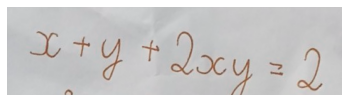

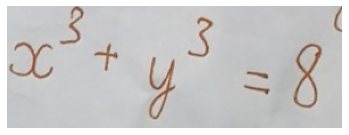

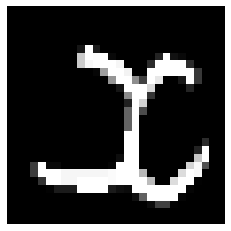

x 0.99998105


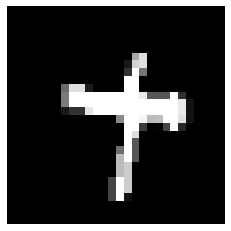

+ 0.99740237


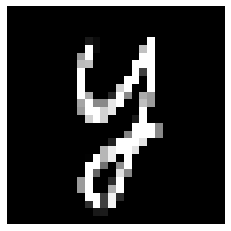

y 0.9999138


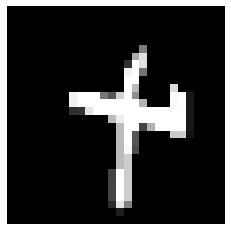

+ 0.99740237


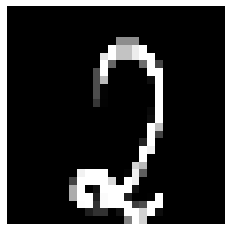

2 0.99977976


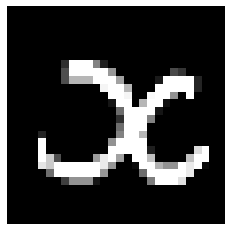

x 0.99999964


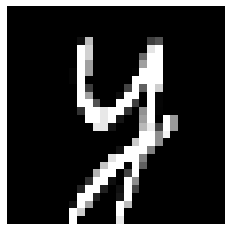

y 0.99872285


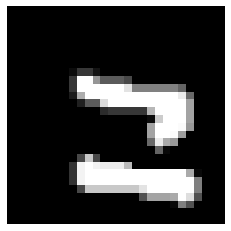

= 0.99944085


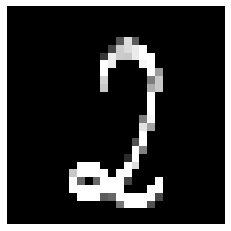

2 0.99935097
x+y+2xy=2
...................................
(107, 295, 3)


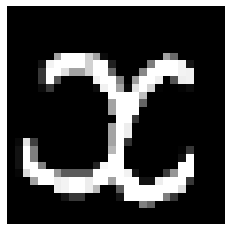

x 0.99999845


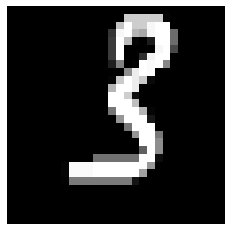

3 1.0


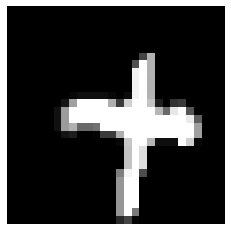

+ 0.99740237


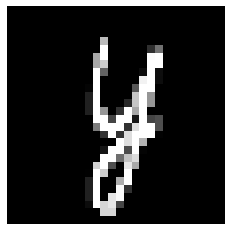

y 0.9997408


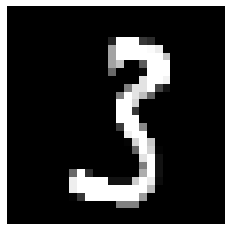

3 1.0


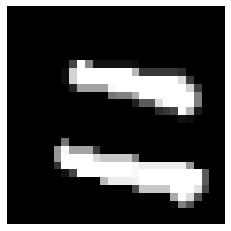

= 0.9999995


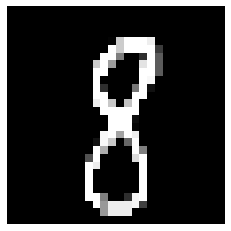

8 1.0


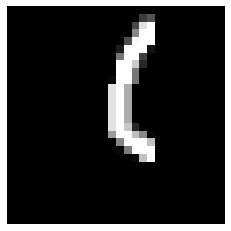

1 0.44145802
x3+y3=8
...................................
['x+y+2xy=2', 'x3+y3=8']
['+x+y+2*x*y-2', '+x**3+y**3-8']
['( x = 0 , y = 2 )', '( x = 2 , y = 0 )', '( x = - \\frac{7}{8} - \\frac{\\sqrt{15} i}{8} + \\frac{1}{8} \\sqrt{-86 + 6 \\sqrt{15} i} , y = - \\frac{7}{8} - \\sqrt{- \\frac{43}{32} + \\frac{3 i}{32} \\sqrt{15}} - \\frac{\\sqrt{15} i}{8} )', '( x = - \\frac{7}{8} + \\frac{\\sqrt{15} i}{8} - \\frac{1}{8} \\sqrt{-86 - 6 \\sqrt{15} i} , y = - \\frac{7}{8} + \\sqrt{- \\frac{43}{32} - \\frac{3 i}{32} \\sqrt{15}} + \\frac{\\sqrt{15} i}{8} )', '( x = - \\frac{7}{8} + \\frac{1}{8} \\sqrt{-86 - 6 \\sqrt{15} i} + \\frac{\\sqrt{15} i}{8} , y = - \\frac{7}{8} + \\frac{\\sqrt{15} i}{8} - \\sqrt{- \\frac{43}{32} - \\frac{3 i}{32} \\sqrt{15}} )', '( x = - \\frac{7}{8} - \\frac{1}{8} \\sqrt{-86 + 6 \\sqrt{15} i} - \\frac{\\sqrt{15} i}{8} , y = - \\frac{7}{8} - \\frac{\\sqrt{15} i}{8} + \\sqrt{- \\frac{43}{32} + \\frac{3 i}{32} \\sqrt{15}} )']


127.0.0.1 - - [07/Nov/2020 02:43:41] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:43:42] "GET /images/original_test10.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:43:42] "GET /images/cropped_test10.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:43:43] "GET /favicon.ico HTTP/1.1" 404 -


<FileStorage: 'test8.jpg' ('image/jpeg')>
Number of object detected: 2
[[354, 307, 610, 463], [367, 582, 621, 326]]
-32.66091537475586
Number of object detected: 3
[[366, 440, 720, 128], [409, 606, 691, 130], [480, 764, 558, 133]]
(128, 725, 3)


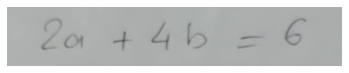

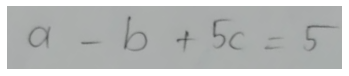

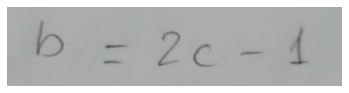

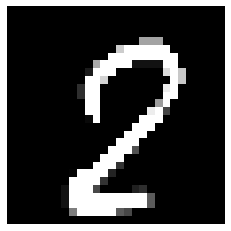

2 0.9999951


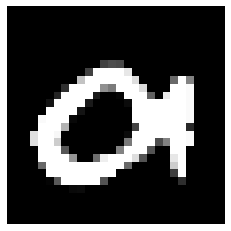

a 0.9995889


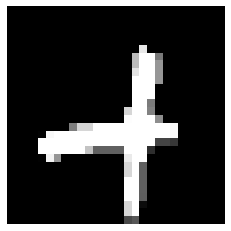

+ 0.99740237


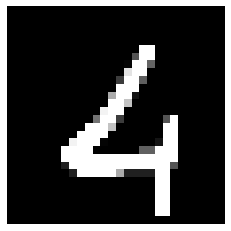

4 0.9999999


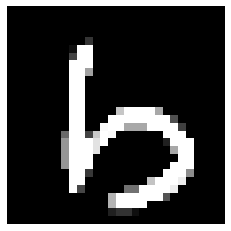

b 0.99999213


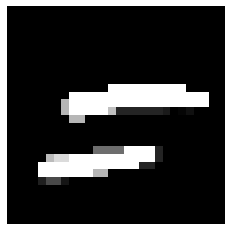

= 0.99999726


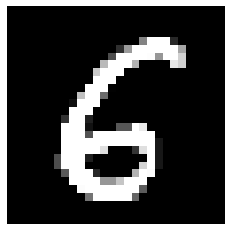

6 0.99999976
2a+4b=6
...................................
(130, 696, 3)


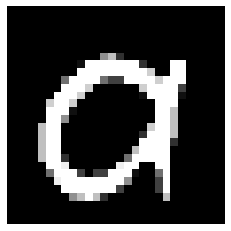

a 0.99983346


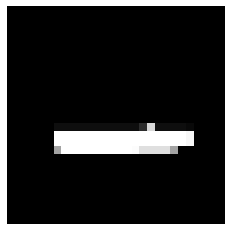

- 0.99596006


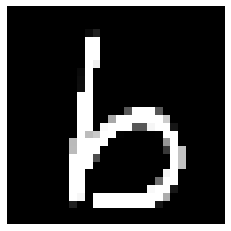

b 0.99999285


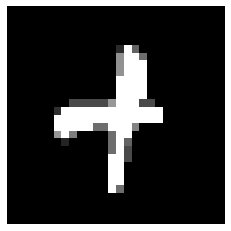

+ 0.99740237


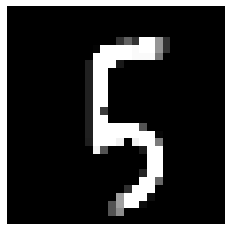

5 0.9999995


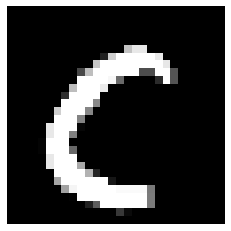

c 0.9999343


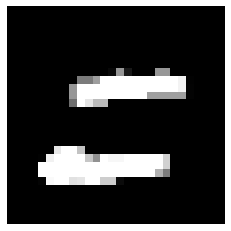

= 0.9999995


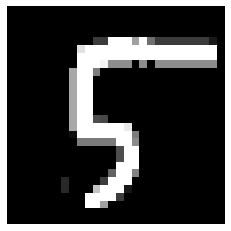

5 1.0
a-b+5c=5
...................................
(133, 563, 3)


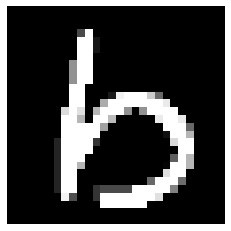

b 0.99997973


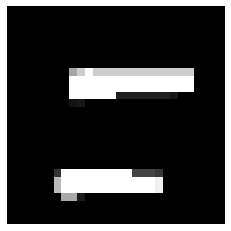

= 0.99999976


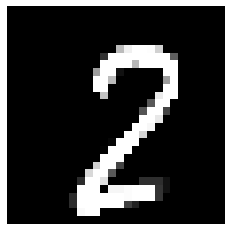

2 0.99987316


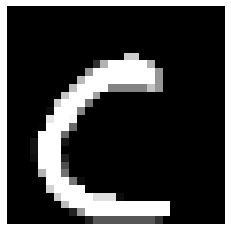

c 0.9999893


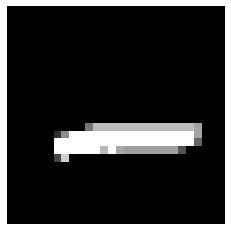

- 0.99530494


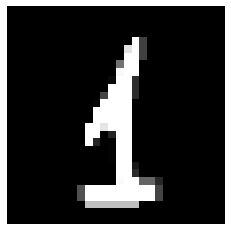

1 0.9999968
b=2c-1
...................................
['2a+4b=6', 'a-b+5c=5', 'b=2c-1']
['+2*a+4*b-6', '+a-b+5*c-5', '+b-2*c+1']
['( a = 1 , b = 1 , c = 1 )']


127.0.0.1 - - [07/Nov/2020 02:44:48] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:44:49] "GET /images/cropped_test8.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:44:49] "GET /images/original_test8.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:44:50] "GET /favicon.ico HTTP/1.1" 404 -


<FileStorage: 'test7.jpg' ('image/jpeg')>
Number of object detected: 1
[[354, 321, 591, 323]]
21.464488983154297
Number of object detected: 3
[[289, 395, 726, 130], [314, 570, 783, 137], [384, 747, 610, 130]]
(130, 731, 3)


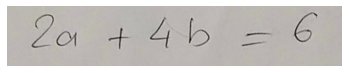

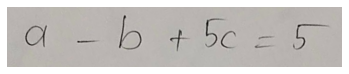

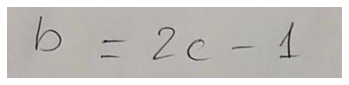

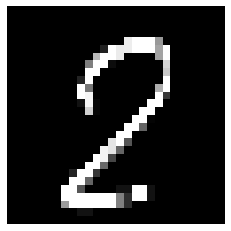

2 0.9999989


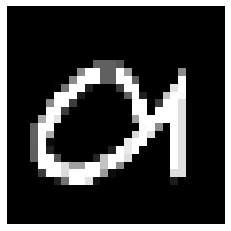

a 0.9999821


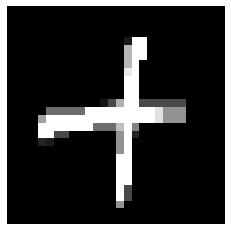

+ 0.99740237


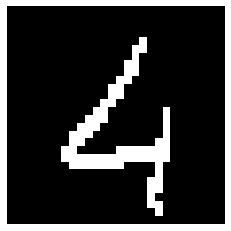

4 1.0


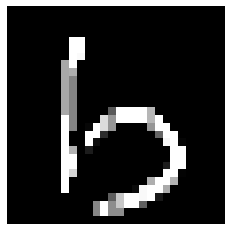

b 0.9998307


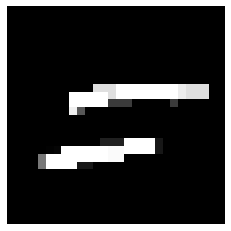

= 0.9999993


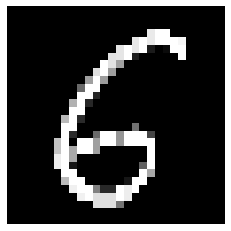

6 0.99999976
2a+4b=6
...................................
(137, 766, 3)


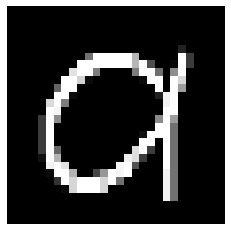

a 0.9999912


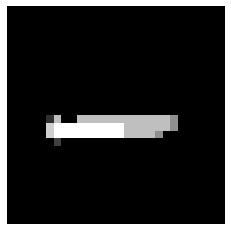

- 0.9955723


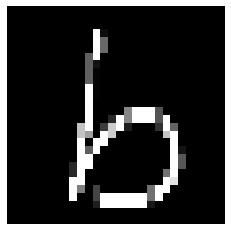

b 0.9997868


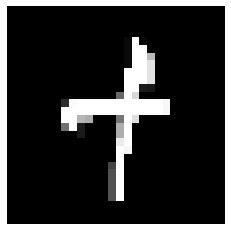

+ 0.99740237


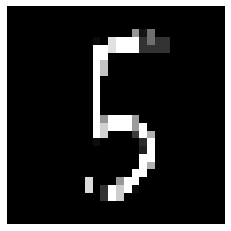

5 0.99999976


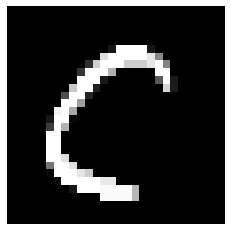

c 0.99989736


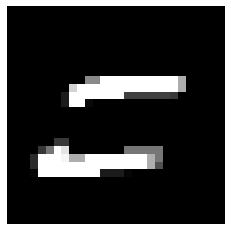

= 0.99999964


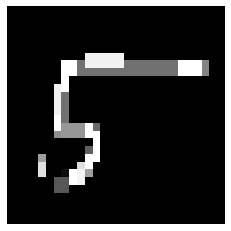

5 0.99999976
a-b+5c=5
...................................
(130, 615, 3)


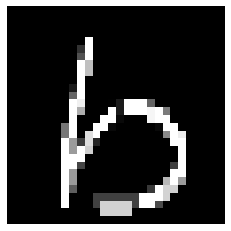

b 0.99938595


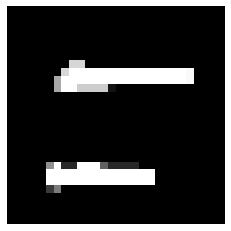

= 0.9999999


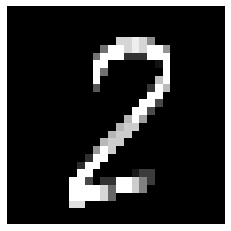

2 0.99988866


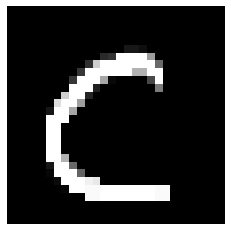

c 0.9999964


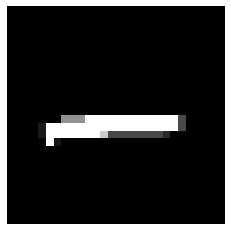

- 0.994806


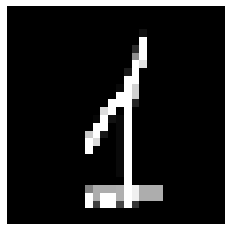

1 0.9986118
b=2c-1
...................................
['2a+4b=6', 'a-b+5c=5', 'b=2c-1']
['+2*a+4*b-6', '+a-b+5*c-5', '+b-2*c+1']
['( a = 1 , b = 1 , c = 1 )']


127.0.0.1 - - [07/Nov/2020 02:45:10] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:45:10] "GET /images/original_test7.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:45:11] "GET /images/cropped_test7.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:45:11] "GET /favicon.ico HTTP/1.1" 404 -


<FileStorage: 'test6.jpg' ('image/jpeg')>
Number of object detected: 1
[[83, 572, 789, 192]]
-6.0286865234375
Number of object detected: 1
[[76, 590, 812, 159]]
(159, 817, 3)


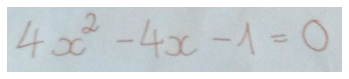

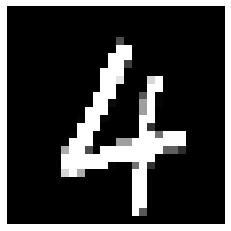

4 1.0


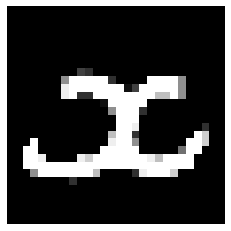

x 0.99999917


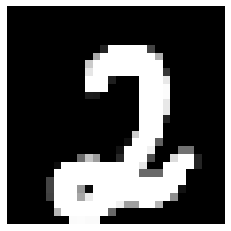

2 0.99996173


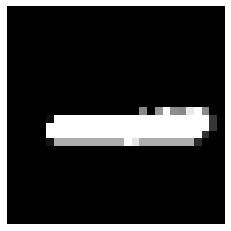

- 0.99188316


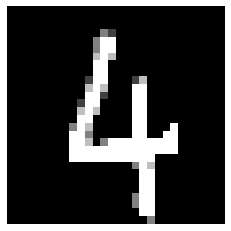

4 1.0


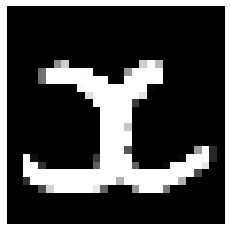

x 0.9999924


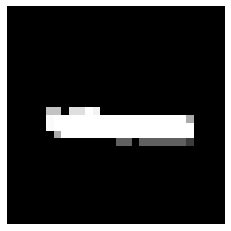

- 0.99214983


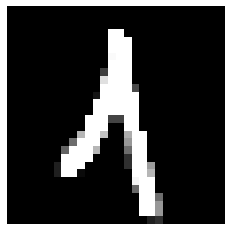

1 0.9999776


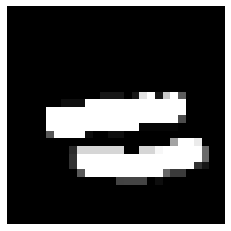

= 0.99908507


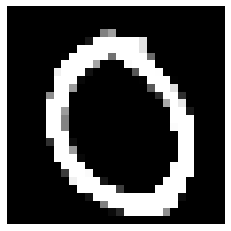

0 0.99994147
4x2-4x-1=0
...................................
['4x2-4x-1=0']
['+4*x**2-4*x-1-0']
['( x = \\frac{1}{2} + \\frac{\\sqrt{2}}{2} )', '( x = - \\frac{\\sqrt{2}}{2} + \\frac{1}{2} )']


127.0.0.1 - - [07/Nov/2020 02:45:30] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:45:31] "GET /images/original_test6.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:45:31] "GET /images/cropped_test6.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:45:32] "GET /favicon.ico HTTP/1.1" 404 -


<FileStorage: 'test4.png' ('image/png')>
Number of object detected: 1
[[3, 62, 609, 200]]
-0.553558349609375
Number of object detected: 1
[[11, 65, 621, 194]]
(194, 626, 3)


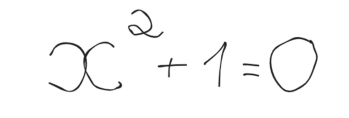

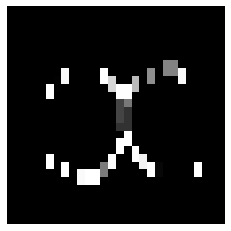

x 0.999879


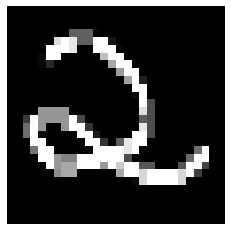

2 0.9991425


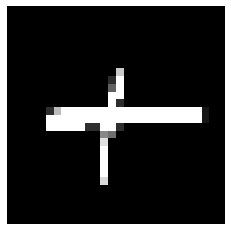

+ 0.99740237


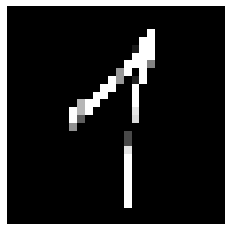

1 0.99999225


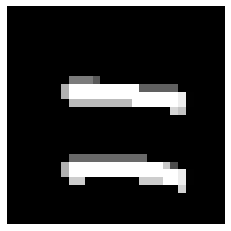

= 0.9999995


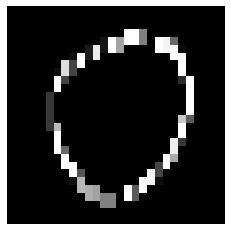

0 0.9997712
x2+1=0
...................................
['x2+1=0']
['+x**2+1-0']
['( x = - i )', '( x = i )']


127.0.0.1 - - [07/Nov/2020 02:45:51] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:45:51] "GET /images/original_test4.png HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:45:51] "GET /images/cropped_test4.png HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:45:52] "GET /favicon.ico HTTP/1.1" 404 -


<FileStorage: 'test3.jpg' ('image/jpeg')>
Number of object detected: 2
[[38, 340, 517, 163], [74, 492, 462, 215]]
-11.338623046875
Number of object detected: 2
[[71, 497, 513, 155], [93, 350, 482, 152]]
(152, 487, 3)


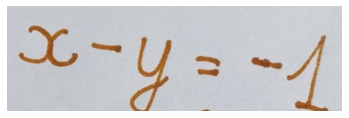

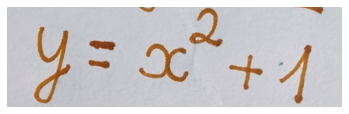

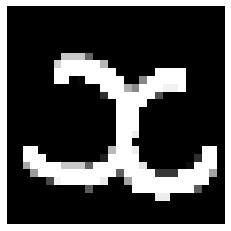

x 0.99999976


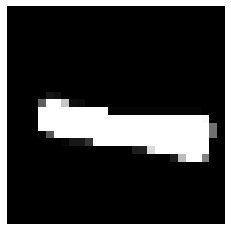

- 0.9946201


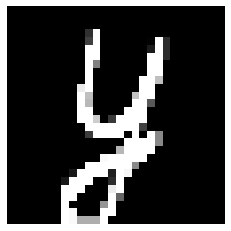

y 0.9984268


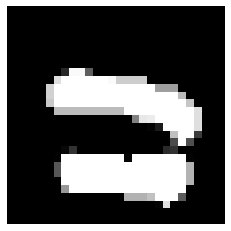

= 0.99896014


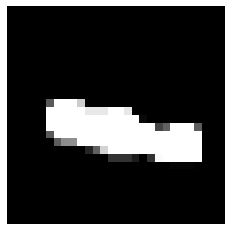

- 0.9833667


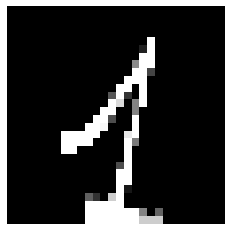

1 0.999879
x-y=-1
...................................
(155, 518, 3)


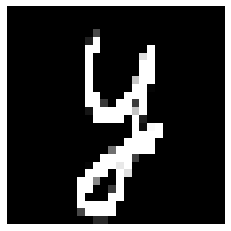

y 0.9997378


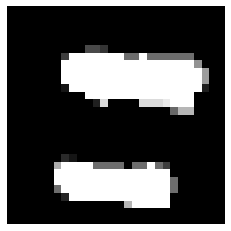

= 0.99840945


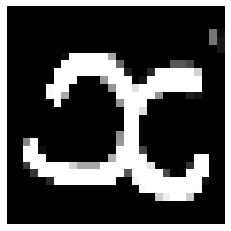

x 0.99999976


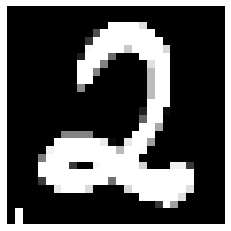

2 0.99990714


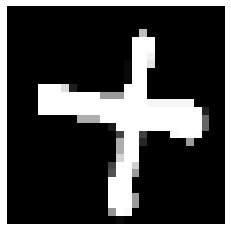

+ 0.99740237


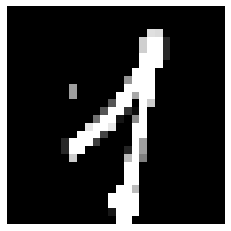

1 0.999966
y=x2+1
...................................
['x-y=-1', 'y=x2+1']
['+x-y+1', '+y-x**2-1']
['( x = 0 , y = 1 )', '( x = 1 , y = 2 )']


127.0.0.1 - - [07/Nov/2020 02:46:07] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:46:07] "GET /images/original_test3.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:46:07] "GET /images/cropped_test3.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:46:08] "GET /favicon.ico HTTP/1.1" 404 -


<FileStorage: 'original_IMG_20201025_213726.jpg' ('image/jpeg')>
Number of object detected: 3
[[93, 468, 1315, 188], [97, 680, 1466, 225], [203, 927, 1346, 265]]
-1.6651077270507812
Number of object detected: 3
[[100, 687, 1469, 210], [111, 467, 1390, 181], [190, 936, 1365, 253]]
(181, 1395, 3)


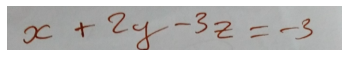

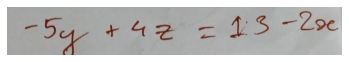

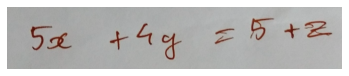

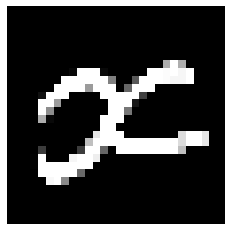

x 0.99999964


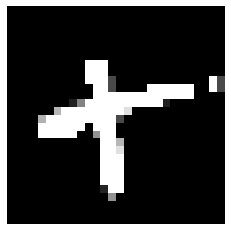

+ 0.99740237


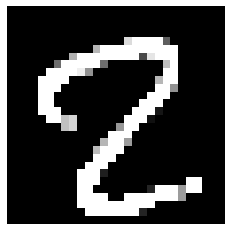

2 0.99981123


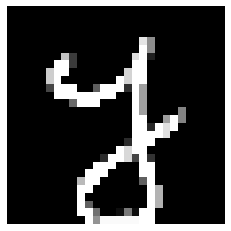

y 0.9999032


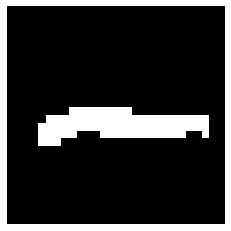

- 0.95558536


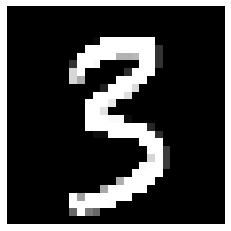

3 1.0


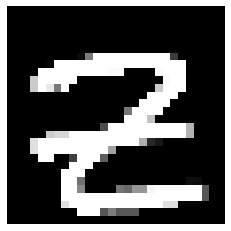

z 0.99993074


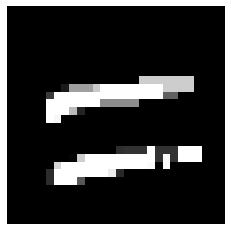

= 0.99999917


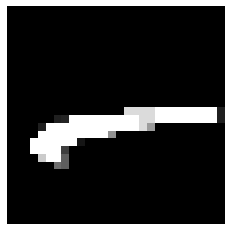

- 0.99847215


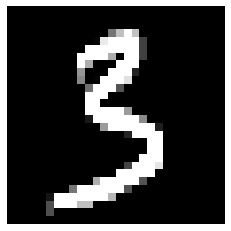

3 1.0
x+2y-3z=-3
...................................
(210, 1474, 3)


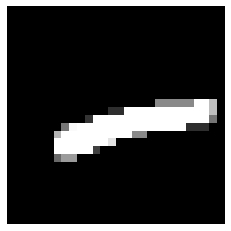

- 0.99849164


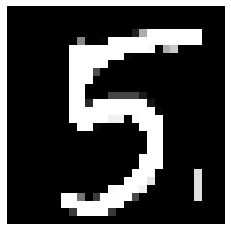

5 0.9999515


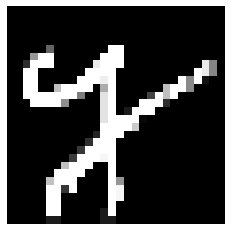

y 0.9925029


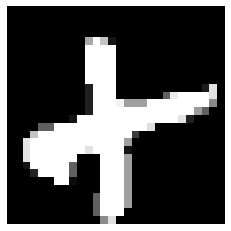

+ 0.99740237


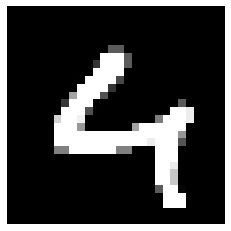

4 1.0


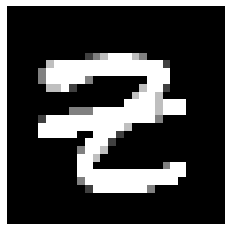

z 0.9997496


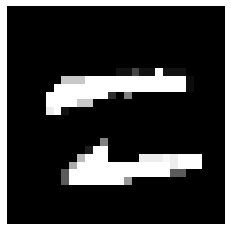

= 0.9999877


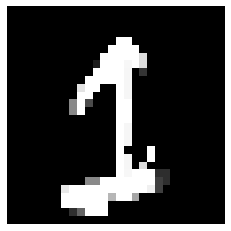

1 0.9999989


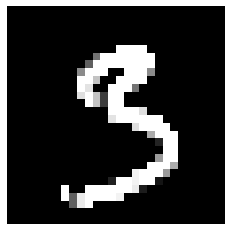

3 1.0


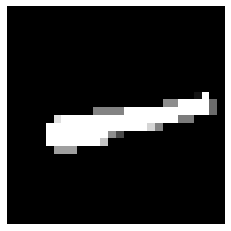

- 0.99868184


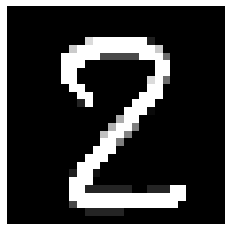

2 0.999286


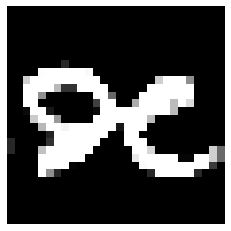

x 0.99971193
-5y+4z=13-2x
...................................
(253, 1370, 3)


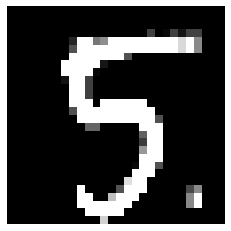

5 0.99999666


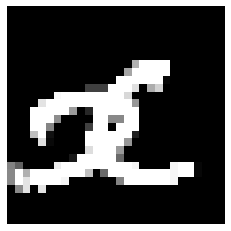

x 0.99687105


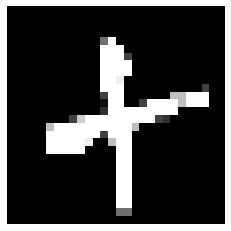

+ 0.99740237


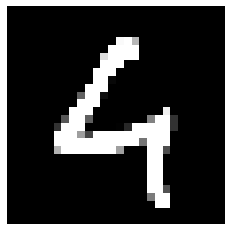

4 1.0


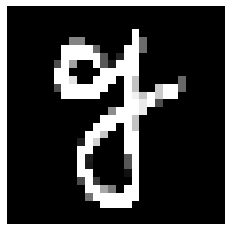

y 0.9995993


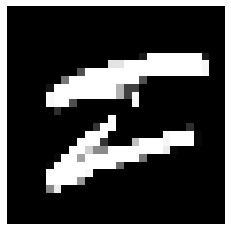

= 0.9948211


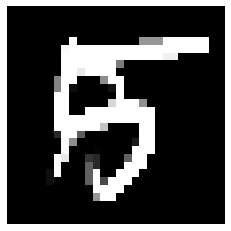

5 0.99998593


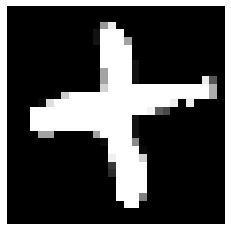

+ 0.99740237


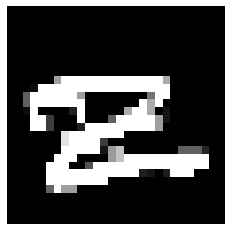

z 0.92087
5x+4y=5+z
...................................
['x+2y-3z=-3', '-5y+4z=13-2x', '5x+4y=5+z']
['+x+2*y-3*z+3', '-5*y+4*z-13+2*x', '+5*x+4*y-5-z']
['( x = 2 , y = -1 , z = 1 )']


127.0.0.1 - - [07/Nov/2020 02:46:57] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:46:57] "GET /images/original_original_IMG_20201025_213726.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:46:57] "GET /images/cropped_original_IMG_20201025_213726.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:46:58] "GET /favicon.ico HTTP/1.1" 404 -


<FileStorage: 'test2.jpg' ('image/jpeg')>
Number of object detected: 2
[[209, 473, 232, 77], [210, 557, 256, 80]]
-7.672416687011719
Number of object detected: 2
[[193, 551, 258, 85], [204, 473, 238, 70]]
(70, 243, 3)


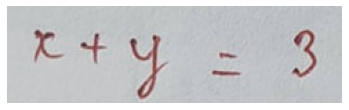

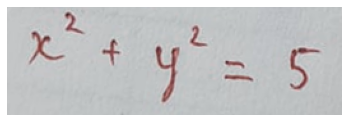

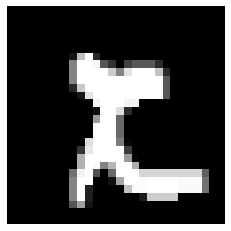

x 0.9999932


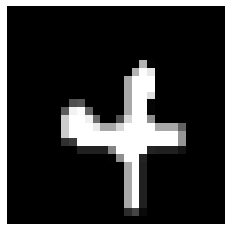

+ 0.99740237


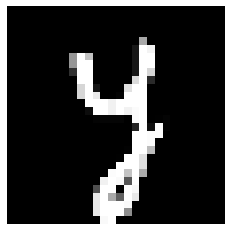

y 0.9999503


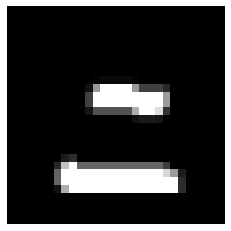

= 0.99999106


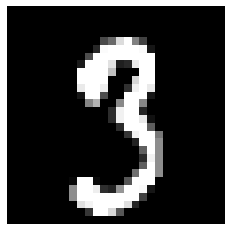

3 1.0
x+y=3
...................................
(85, 263, 3)


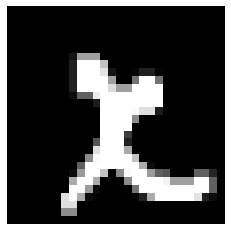

x 0.99999774


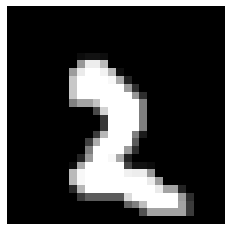

2 0.9896814


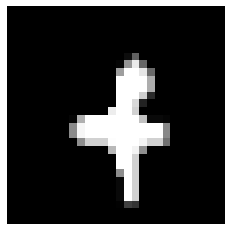

+ 0.99740237


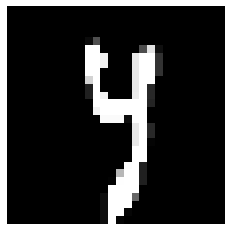

y 0.9997789


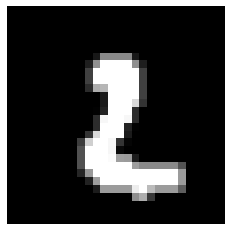

2 0.98184586


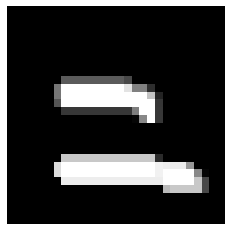

= 0.99997234


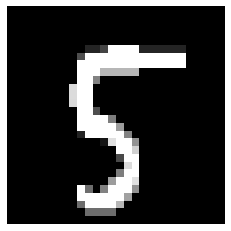

5 0.9999999
x2+y2=5
...................................
['x+y=3', 'x2+y2=5']
['+x+y-3', '+x**2+y**2-5']
['( x = 1 , y = 2 )', '( x = 2 , y = 1 )']


127.0.0.1 - - [07/Nov/2020 02:47:18] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:47:19] "GET /images/cropped_test2.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:47:19] "GET /images/original_test2.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:47:20] "GET /favicon.ico HTTP/1.1" 404 -


<FileStorage: 'original_13.jpg' ('image/jpeg')>
Number of object detected: 2
[[493, 35, 555, 177], [493, 226, 530, 157]]
0.6295985579490662
Number of object detected: 2
[[489, 33, 555, 179], [493, 225, 530, 162]]
(179, 560, 3)


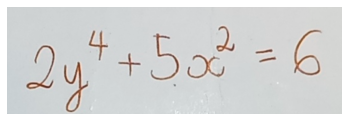

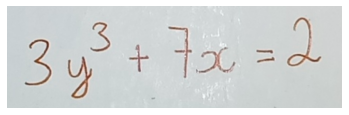

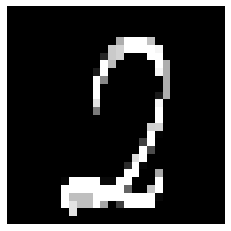

2 0.99982774


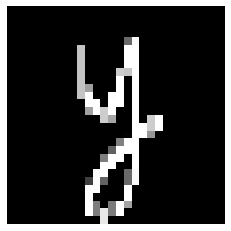

y 0.9999316


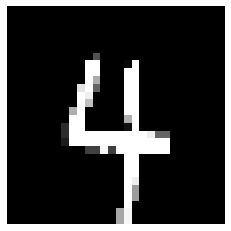

4 1.0


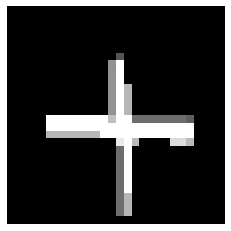

+ 0.99740237


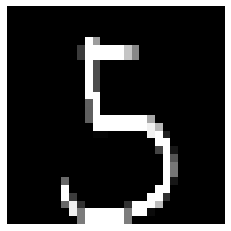

5 0.99999917


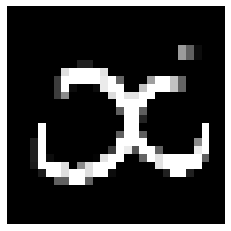

x 0.99999344


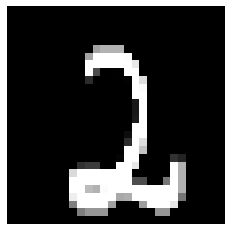

2 0.9998301


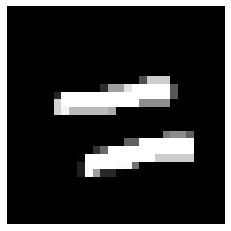

= 0.99999976


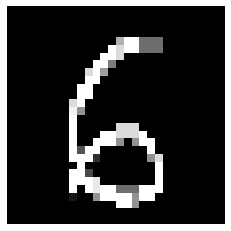

6 0.9999995
2y4+5x2=6
...................................
(162, 535, 3)


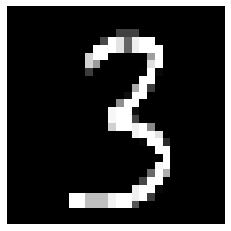

3 1.0


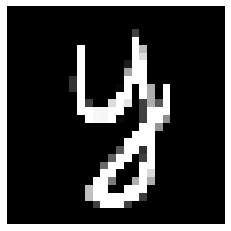

y 0.9995732


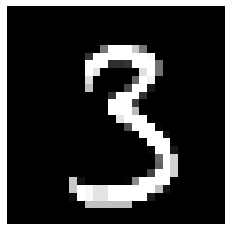

3 1.0


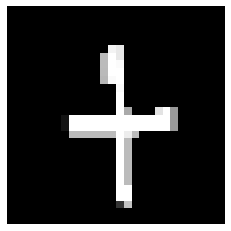

+ 0.99740237


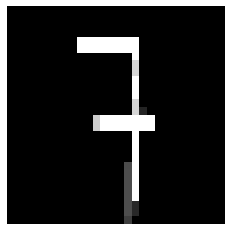

7 0.99912363


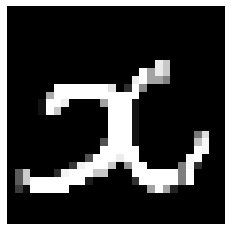

x 0.99998987


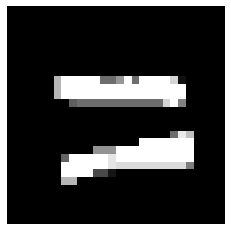

= 0.99999976


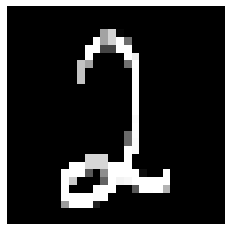

2 0.999814
3y3+7x=2
...................................
['2y4+5x2=6', '3y3+7x=2']
['+2*y**4+5*x**2-6', '+3*y**3+7*x-2']
['PHƯƠNG TRÌNH VÔ NGHIỆM']


127.0.0.1 - - [07/Nov/2020 02:47:37] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:47:37] "GET /images/original_original_13.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:47:38] "GET /images/cropped_original_13.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:47:38] "GET /favicon.ico HTTP/1.1" 404 -


<FileStorage: 'original_10.jpg' ('image/jpeg')>
Number of object detected: 2
[[164, 540, 438, 113], [170, 403, 411, 112]]
0.0
Number of object detected: 2
[[164, 540, 438, 113], [170, 403, 411, 112]]
(112, 416, 3)


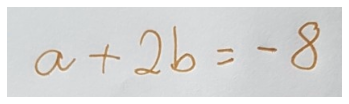

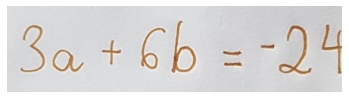

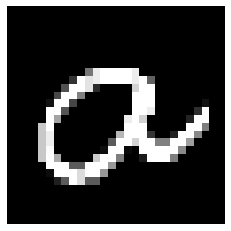

a 1.0


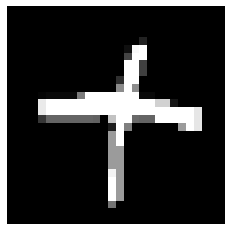

+ 0.99740237


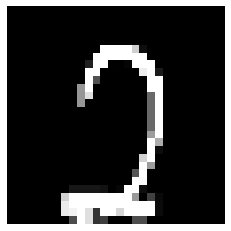

2 0.99819094


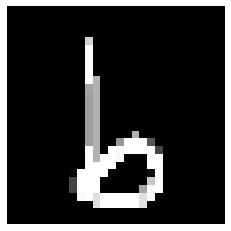

b 0.9999993


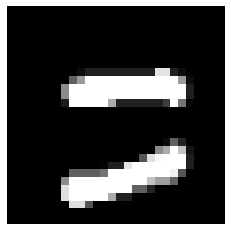

= 0.99999845


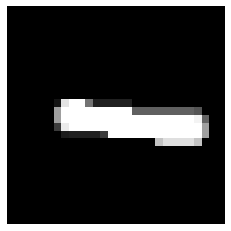

- 0.9927898


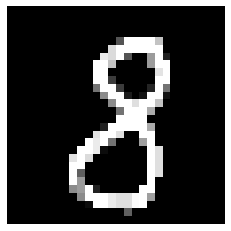

8 1.0
a+2b=-8
...................................
(113, 443, 3)


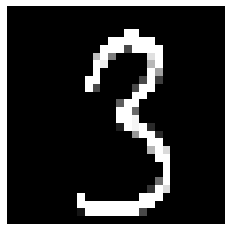

3 1.0


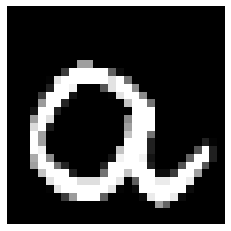

a 0.99999976


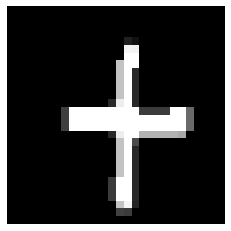

+ 0.99740237


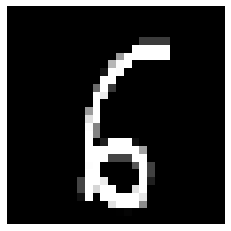

6 1.0


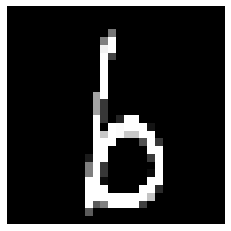

b 0.999964


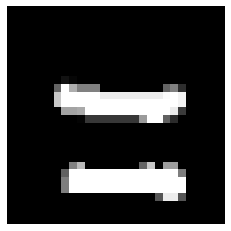

= 0.9999684


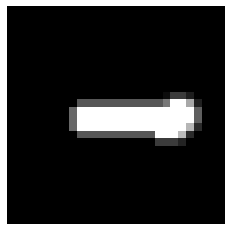

- 0.9973816


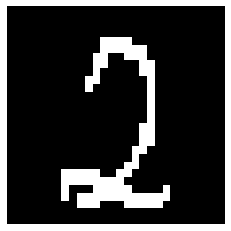

2 0.9996785


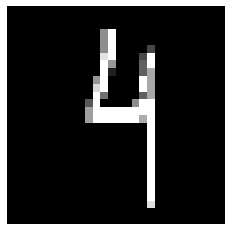

4 1.0
3a+6b=-24
...................................
['a+2b=-8', '3a+6b=-24']
['+a+2*b+8', '+3*a+6*b+24']


127.0.0.1 - - [07/Nov/2020 02:47:58] "POST / HTTP/1.1" 200 -


['( a = - 2 b - 8 )']


127.0.0.1 - - [07/Nov/2020 02:47:58] "GET /images/original_original_10.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:47:58] "GET /images/cropped_original_10.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:47:59] "GET /favicon.ico HTTP/1.1" 404 -


<FileStorage: 'IMG268.jpg' ('image/jpeg')>
Number of object detected: 3
[[444, 1185, 1867, 482], [454, 1560, 1956, 563], [535, 788, 1848, 399]]
-6.6597442626953125
Number of object detected: 3
[[320, 1596, 2115, 473], [490, 1225, 1893, 413], [627, 752, 1794, 473]]
(473, 1799, 3)


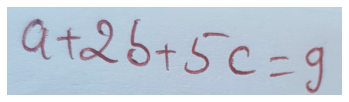

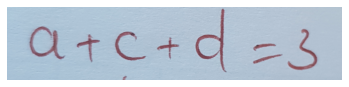

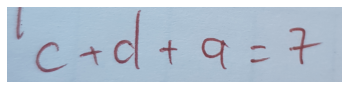

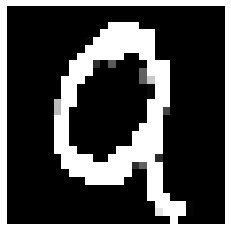

a 0.99999964


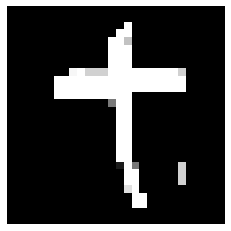

+ 0.99740237


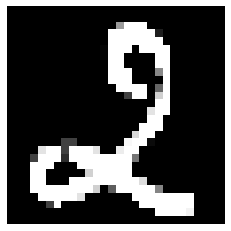

2 0.99999774


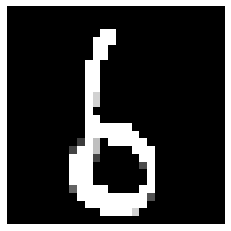

6 0.46285516


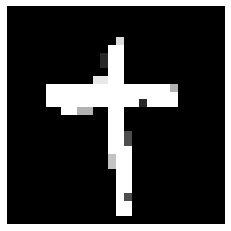

+ 0.99740237


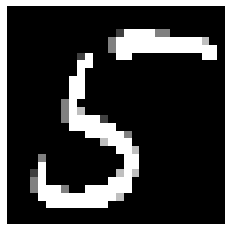

5 0.9999999


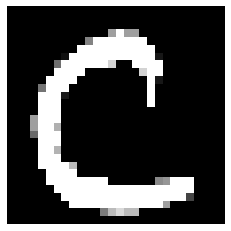

c 0.99999964


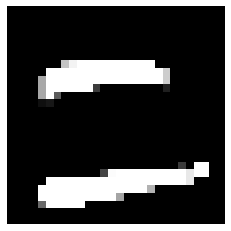

= 0.999995


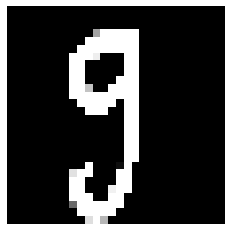

9 0.9999871
a+2+5c=9
...................................
(413, 1898, 3)


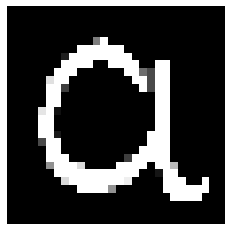

a 0.99999976


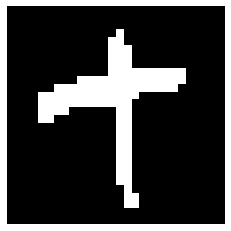

+ 0.99740237


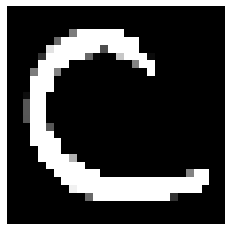

c 0.99999964


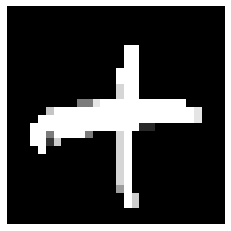

+ 0.99740237


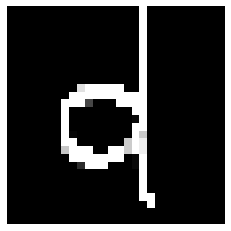

d 0.9999951


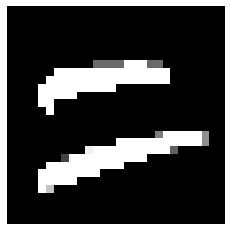

= 0.99999964


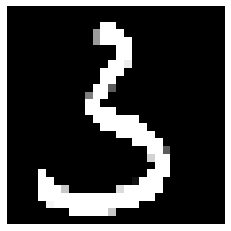

3 1.0
a+c+d=3
...................................
(473, 2120, 3)


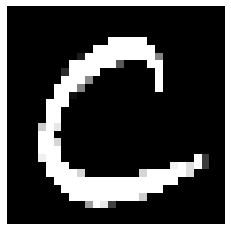

c 0.9999956


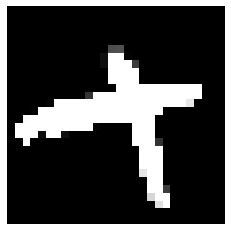

+ 0.99740237


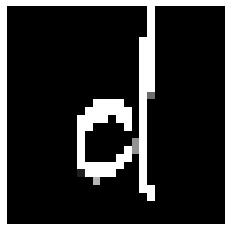

d 0.9999993


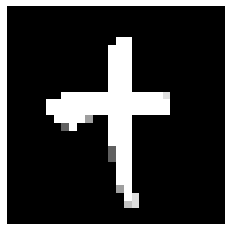

+ 0.99740237


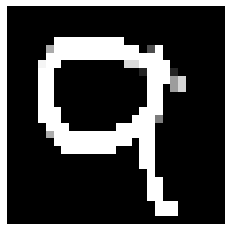

a 0.99136984


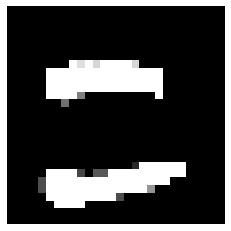

= 0.9999957


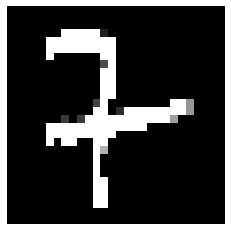

7 0.9990396
c+d+a=7
...................................
['a+2+5c=9', 'a+c+d=3', 'c+d+a=7']
['+a+2+5*c-9', '+a+c+d-3', '+c+d+a-7']
['PHƯƠNG TRÌNH VÔ NGHIỆM']


127.0.0.1 - - [07/Nov/2020 02:48:37] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:48:37] "GET /images/original_IMG268.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:48:37] "GET /images/cropped_IMG268.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:48:39] "GET /favicon.ico HTTP/1.1" 404 -


<FileStorage: '3.jpg' ('image/jpeg')>
Number of object detected: 3
[[160, 438, 969, 239], [209, 624, 987, 280], [259, 812, 994, 276]]
-9.111358642578125
Number of object detected: 3
[[162, 464, 1001, 224], [168, 676, 1064, 240], [191, 891, 1061, 206]]
(224, 1006, 3)


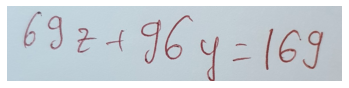

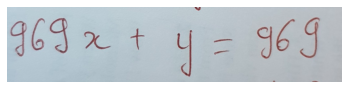

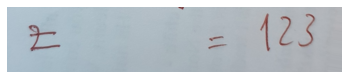

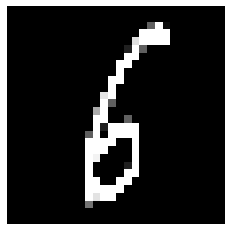

6 0.9999999


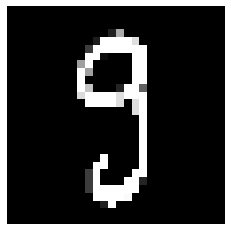

9 0.999956


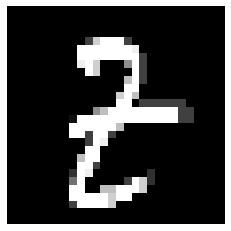

z 0.99890137


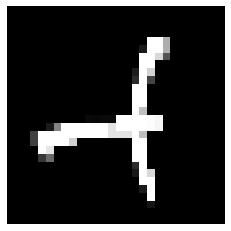

+ 0.99740237


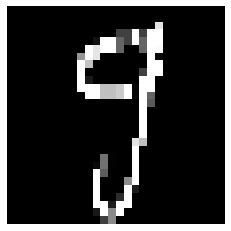

9 0.97018707


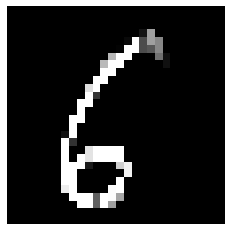

6 1.0


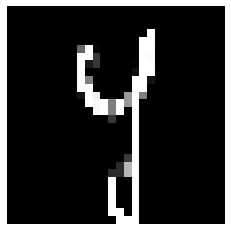

y 0.99973994


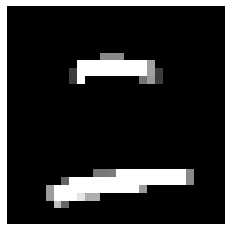

= 0.99999976


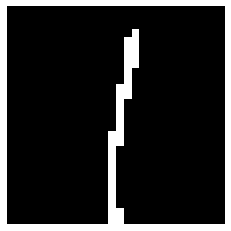

1 0.9998692


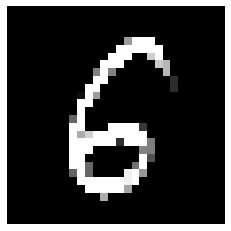

6 0.99999976


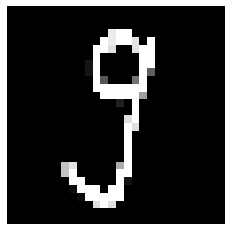

9 0.99894685
69z+96y=169
...................................
(240, 1069, 3)


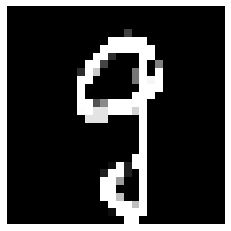

9 0.9977684


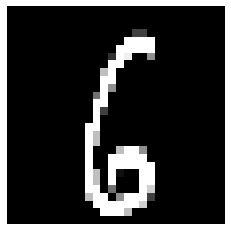

6 1.0


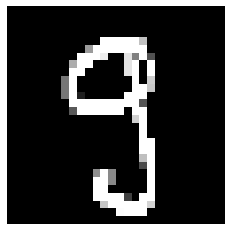

9 0.9999063


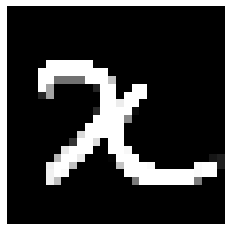

x 0.99999785


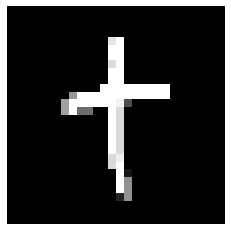

+ 0.99740237


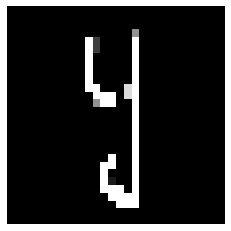

y 0.9998167


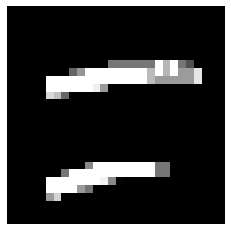

= 0.9999999


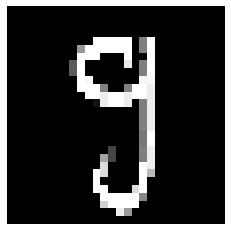

9 0.99980074


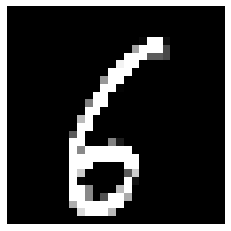

6 1.0


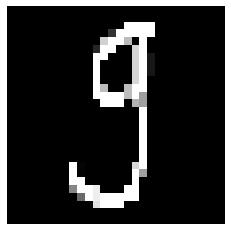

9 0.99325633
969x+y=969
...................................
(206, 1066, 3)


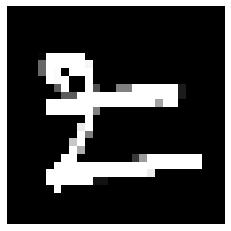

z 0.9963748


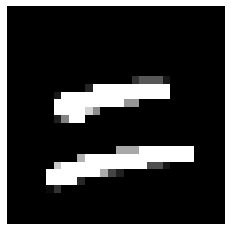

= 0.99999976


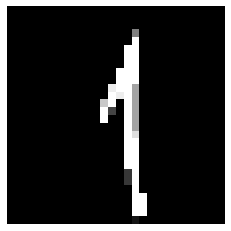

1 0.9999839


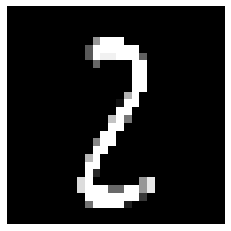

2 0.9540575


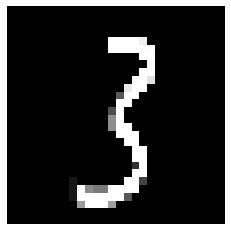

3 1.0
z=123
...................................
['69z+96y=169', '969x+y=969', 'z=123']
['+69*z+96*y-169', '+969*x+y-969', '+z-123']
['( x = \\frac{50671}{46512} , y = - \\frac{4159}{48} , z = 123 )']


127.0.0.1 - - [07/Nov/2020 02:49:51] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:49:51] "GET /images/original_3.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:49:52] "GET /images/cropped_3.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 02:49:53] "GET /favicon.ico HTTP/1.1" 404 -


In [19]:
app  = Flask(__name__, template_folder= "/content/drive/My Drive/Final Project/Khang/templates")
UPLOAD_FOLDER = '/content/drive/My Drive/Final Project/Khang/static/uploads'
app.secret_key = "secret key"
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
app.config['MAX_CONTENT_LENGTH'] = 16 * 1024 * 1024

ALLOWED_EXTENSIONS = set(['png', 'jpg', 'jpeg', 'gif'])

def allowed_file(filename):
	return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

@app.route('/')
def home():
  return render_template("upload.html")

@app.route('/images/<filename>')
def images(filename):
  image_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
  return send_file(image_path)

@app.route('/', methods=['GET','POST'])
def upload_image():
  if request.method == 'POST' :
    file = request.files['file']
    print(file)
    if file and allowed_file(file.filename):
      filename = secure_filename(file.filename)
      full_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
      file.save(full_path)
      #Predict
      soe_image, result, list_text_equation = soe_solver(full_path)
      #Image cropped
      cv2.imwrite(app.config['UPLOAD_FOLDER']+ '/cropped_'+filename, soe_image)
      soe_image = cv2.copyMakeBorder(soe_image, 0,0,10,0, cv2.BORDER_CONSTANT, value = [0,0,0])
      image_cropped_url = url_for('images', filename ='cropped_' +filename)
      #Original image
      original_image = cv2.imread(full_path)
      original_image = cv2.copyMakeBorder(original_image, 0,0,0,10, cv2.BORDER_CONSTANT, value =[0,0,0])
      cv2.imwrite(app.config['UPLOAD_FOLDER']+ '/original_'+filename, original_image)
      original_image_url = url_for('images', filename ='original_' +filename)

      return render_template("upload.html", original_image = original_image_url, cropped_image = image_cropped_url, result = result, text = list_text_equation )
  else :
    return redirect("/")

if __name__ == "__main__" :
  app.run()


